In [305]:
import os
import csv
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join

import torch         # 2.0.1+cpu
import torchaudio    # 2.0.2+cpu
import torchaudio.functional as F
import torchaudio.transforms as T

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import re
import matplotlib.pyplot as plt

## Data curation 

### [Model_1]

In [306]:
dir_model_1 = "Respiratory_Sound_Database\\Respiratory_Sound_Database\\Respiratory_Sound_Database\\"
data_dir_path_1 = dir_model_1 + "audio_and_txt_files\\"

In [307]:
def get_wav_files(mypath : str = dir_model_1 + r'audio_and_txt_files'):
    filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))]
    return filenames

In [308]:
filenames = get_wav_files(dir_model_1 + r'audio_and_txt_files')
# filenames

In [309]:
output_csv = dir_model_1 + "output.csv"
pattern = r'[_\.]'
data = [re.split(pattern, filename)[:-1] for filename in filenames]
header = ["Patient_ID", "Recording_Index", "Location", "Acoustic_Channel", "Equipment"]
data.insert(0, header)
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

In [310]:
org_paitent_diagnosis = dir_model_1+"patient_diagnosis.csv"
p_diag = pd.read_csv(org_paitent_diagnosis, header=None, names=["Patient_ID", "Diagnosis"])
(p_diag)

,Patient_ID,Diagnosis
0,Patient_ID,Diagnosis
1,101,URTI
2,102,Healthy
3,103,Asthma
4,104,COPD
...,...,...
122,222,COPD
123,223,COPD
124,224,Healthy
125,225,Healthy


In [311]:
df1 = pd.read_csv(org_paitent_diagnosis)
df2 = pd.read_csv(output_csv)

merged_df = pd.merge(df1, df2, on='Patient_ID')
merged_df.to_csv(dir_model_1+"patient_details_final.csv", index=False)

print(merged_df.head())

   Patient_ID Diagnosis Recording_Index Location Acoustic_Channel Equipment
0         101      URTI             1b1       Al               sc  Meditron
1         101      URTI             1b1       Pr               sc  Meditron
2         102   Healthy             1b1       Ar               sc  Meditron
3         103    Asthma             2b2       Ar               mc  LittC2SE
4         104      COPD             1b1       Al               sc  Litt3200


##### Cleaning


In [312]:
file_to_delete = output_csv
if os.path.exists(file_to_delete):
    os.remove(file_to_delete)

# Pre-modelling

## audio preprocessing

### normalization

In [313]:
#normalize of audio (amplitute) -1 1
from pydub import AudioSegment

def processing_amplitude(output_directory : str):
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Set the target amplitude range (0 to 1)
    target_amplitude = -20.0  # In dBFS

    dummy = 0
    # Iterate through the audio files in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith(".wav"):

            input_path = os.path.join(input_directory, filename)
            output_path = os.path.join(output_directory, filename)

            # Load the audio file
            audio = AudioSegment.from_mp3(input_path)

            # Normalize the audio to the target amplitude
            normalized_audio = audio.apply_gain(target_amplitude - audio.dBFS)

            # Export the normalized audio as an MP3 file
            normalized_audio.export(output_path, format="wav")

            print(f"Normalized: {input_path}")
            
        dummy += 1
        if dummy == 10:
            break

# Directory containing your audio files
input_directory = r"Respiratory_Sound_Database\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files"
# Directory to save the normalized files
output_directory = r"Respiratory_Sound_Database\Respiratory_Sound_Database\Respiratory_Sound_Database\anp_adjusted\\"

processing_amplitude(output_directory = output_directory)


Normalized: Respiratory_Sound_Database\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files\101_1b1_Al_sc_Meditron.wav
Normalized: Respiratory_Sound_Database\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files\101_1b1_Pr_sc_Meditron.wav
Normalized: Respiratory_Sound_Database\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files\102_1b1_Ar_sc_Meditron.wav
Normalized: Respiratory_Sound_Database\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files\103_2b2_Ar_mc_LittC2SE.wav
Normalized: Respiratory_Sound_Database\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files\104_1b1_Al_sc_Litt3200.wav


In [314]:
# import torchaudio.transforms as T

# # transform to normalize the audio
# class NormalizeAudio:
#     def __init__(self):
#         self.normalize = T.Resample(orig_freq=44100, new_freq=16000)

#     def __call__(self, waveform):
#         return self.normalize(waveform)


# # wav_file_path = 'some_audio.wav'

# # # Load the .wav file to get sample rate
# # waveform, sample_rate = torchaudio.load(wav_file_path)

# # print(f'The sample rate of the audio is {sample_rate} Hz.')

### Uniforming length of  audio file

##### helper functions

In [315]:
def len_wav(path : str):
    waveform, sample_rate = torchaudio.load(path)
    duration_seconds = waveform.shape[1] / sample_rate
    print(f'The duration of the audio is {duration_seconds} seconds.')

In [316]:
def clip_wav(waveform, sample_rate,desired_duration_samples,output_wav_file : str = 'output.wav'):    
    # Clip to desired duration
    clipped_waveform = waveform[:, :desired_duration_samples]
    # Save to new file
    torchaudio.save(output_wav_file, clipped_waveform, sample_rate)

    return clipped_waveform

In [317]:
# silence = 0 : no wave/silence concat
# silence = -1 : ones concat
# silence = 1 : replay concat
def add_wav(waveform, sample_rate,desired_duration_samples,output_wav_file : str = 'output.wav',silence = 1):
    # Calc amount of silence needed
    silence_samples = desired_duration_samples - waveform.shape[1]

    if silence == 0 : 
        # null silence waveform
        silence_waveform = torch.zeros((waveform.shape[0], silence_samples))
        # Concatenate original + silence
        extended_waveform = torch.cat([waveform, silence_waveform], dim=1)

    elif silence == -1:
        # white noise silence waveform
        silence_waveform = torch.ones((waveform.shape[0], silence_samples))
        # Concatenate original + silence
        extended_waveform = torch.cat([waveform, silence_waveform], dim=1)

    else:
        # replay silence waveform
        rest_waveform = clip_wav(waveform, sample_rate,silence_samples)
        extended_waveform = torch.cat([waveform, rest_waveform], dim=1)
        
    # Save extended audio -> new file
    torchaudio.save(output_wav_file, extended_waveform, sample_rate)  

    return extended_waveform

In [318]:
def uniform_len_wav(input_wav_file : str, output_wav_file : str = 'output.wav',desired_duration_seconds : int = 10,add_wav_type = 1) -> int :
    waveform, sample_rate = torchaudio.load(input_wav_file)
    desired_duration_samples = int(sample_rate * desired_duration_seconds)

    # Check if the input audio is shorter than the desired duration
    if waveform.shape[1] < desired_duration_samples:
        add_wav(waveform, sample_rate,desired_duration_samples,output_wav_file,silence=add_wav_type)
        return 1
    else:
        clip_wav(waveform, sample_rate,desired_duration_samples)
        return 2

##### Saving unform length audio files

In [319]:
dir_uniform_audio = dir_model_1 + 'uniform_audio_files\\'
dir_uniform_audio = 'uniform_audio_files\\'
try:
    os.makedirs(dir_uniform_audio)
    print(f"Folder '{dir_uniform_audio}' has been created.")
except FileExistsError:
    print(f"Folder '{dir_uniform_audio}' already exists.")
except OSError as e:
    print(f"Error: {e}")

Folder 'uniform_audio_files\' already exists.


In [320]:
filenames_all_wav = get_wav_files()
filenames_all_wav[:4]

['101_1b1_Al_sc_Meditron.wav',
 '101_1b1_Pr_sc_Meditron.wav',
 '102_1b1_Ar_sc_Meditron.wav',
 '103_2b2_Ar_mc_LittC2SE.wav']

In [321]:
uniformed_wav_length = 7
# [0 for clip; 1 for add]
def uniform_len_wav_create(uniformed_wav_length = 7) -> int:
    actions = []
    # for i in range(len(filenames_all_wav)):
    for i in range(1):
        instance_file_path = filenames_all_wav[i]
        input_wav_file_path = data_dir_path_1 + instance_file_path
        print(input_wav_file_path)
        output_wav_file_path = dir_uniform_audio + instance_file_path
        print(output_wav_file_path)
        # check if wav file is empty or not
        if os.path.getsize(input_wav_file_path) > 0:
            actions.append(uniform_len_wav(input_wav_file_path,output_wav_file=output_wav_file_path,desired_duration_seconds=uniformed_wav_length,add_wav_type=1))
        else:
            print("File is empty")
        # actions.append(uniform_len_wav(input_wav_file_path,output_wav_file_path,uniformed_wav_length,add_wav_type=1))

uniform_len_wav_create()

Respiratory_Sound_Database\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files\101_1b1_Al_sc_Meditron.wav
uniform_audio_files\101_1b1_Al_sc_Meditron.wav


##### trash ig

In [322]:
# import os
# import subprocess

# file_path = dir_model_1

# if os.access(file_path, os.R_OK):
#     print("Read permission is granted.")
# else:
#     print("Read permission is denied.")

# if os.access(file_path, os.W_OK):
#     print("Write permission is granted.")
# else:
#     print("Write permission is denied.")


# subprocess.run(["icacls", file_path, "/grant", "*S-1-1-0:(R,W)"])



### audio feature creation/convertion

In [323]:
# torchaudio.transforms.Spectrogram()

# Mel-Spectogram is preferred in literature, therefore defualt
def spectrogram(instance_file_path : str, _n_lfcc : int = 40, _n_mfcc : int = 512,type : int = 4, verbose = 0):
    # Load audio
    waveform, SAMPLE_RATE = torchaudio.load(instance_file_path)
    if verbose : print(f'waveform shape: {waveform.shape}; SAMPLE_RATE: {SAMPLE_RATE}')
    # Define transform
    if(type == 0) : spectrogram = T.Spectrogram(power=None)  # Raw Spectrogram (complex-valued)
    if(type == 1) : spectrogram = T.Spectrogram(power=2)  # Power Spectrogram (real-valued)
    if(type == 2) : spectrogram = T.LFCC(sample_rate=SAMPLE_RATE, n_lfcc=_n_lfcc)  #(n_lfcc -> parameter) Linear Frequency Cepstral Coefficient
    if(type == 3) : spectrogram = T.MFCC(sample_rate=SAMPLE_RATE, n_mfcc=_n_mfcc)  #(n_fft -> parameter) Mel Frequency Cepstral Coefficient
    if(type == 4) : spectrogram = T.MelSpectrogram(sample_rate=SAMPLE_RATE)  # Mel-scale Spectogram
    if(type == 5) :
        # Compute the zero-crossing rate
        zero_crossing_rate = torchaudio.transforms.ZeroCrossingRate()(waveform)
        # Calculate the mean zero-crossing rate
        mean_zero = zero_crossing_rate.mean(dim=1)
        mean_zero = mean_zero.numpy()

        return mean_zero
    if(type == 6) : 
        # Compute the Short-Time Fourier Transform (STFT)
        spectrogram = T.Spectrogram()(waveform)
        # Compute the chroma feature from the STFT
        chroma = T.Chroma()(spectrogram)
        # Calculate the mean along the time axis
        chroma_mean = chroma.mean(dim=2)
        # Convert the result to a NumPy array if needed
        chroma_mean = chroma_mean.numpy()

        return chroma
    if(type == 7) :
        # Calculate the RMS using torchaudio's rms function
        rms = torchaudio.transforms.RMS()(waveform)
        # Calculate the mean along the time axis
        rms_mean = rms.mean(dim=1)

        return rms_mean
    # Perform transform
    spec = spectrogram(waveform)
    return spec

In [324]:
# instance_file_path1 = 'Respiratory_Sound_Database\\Respiratory_Sound_Database\\Respiratory_Sound_Database\\audio_and_txt_files\\' +'101_1b1_Al_sc_Meditron.wav'
# instance_file_path2 = 'Respiratory_Sound_Database\\Respiratory_Sound_Database\\Respiratory_Sound_Database\\audio_and_txt_files\\' +'103_2b2_Ar_mc_LittC2SE.wav'
# output_wav_file = 'output.wav'
# spec1 = spectrogram(instance_file_path1,verbose=0)
# spec2 = spectrogram(instance_file_path2,verbose=0)
# print(spec1.flatten().shape)
# print(spec2.flatten().shape)

In [325]:
# data_path = dir_model_1 + "audio_and_txt_files\\"

for wav in filenames_all_wav:
    instance_file_path = data_dir_path_1 + wav
    output_wav_file = dir_uniform_audio + wav

    spec = spectrogram(instance_file_path,verbose=0)
    print(spec.flatten().shape)

C:\Users\lakshay\AppData\Roaming\Python\Python310\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([40704])
torch.Size([65536])
torch.Size([47360])
torch.Size([38528])
torch.Size([58880])
torch.Size([60800])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([564608])
torch.Size([52096])
torch.Size([51200])
torch.Size([43392])
torch.Size([44800])
torch.Size([45184])
torch.Size([76928])
torc

### Feature Selection

In [326]:
feature_list = ['Recording Index', 'Location', 'Region', 'Acoustic Channel', 'Sound Type', 'Diagnosis', 'Equipment', 'Age', 'Sex', 'Adult BMI', 'Child Weight', 'Child Height']

def feature_selection(save_csv : bool = True,csv_name : str = 'tmp.csv', verbose : int  = 0, label_bool = True, manual : bool = False):
    print('Following are the set of features available: ')
    for i in range(len(feature_list)):
        print(i," "+ feature_list[i])

    attributes=[1,2,3,4,5,6]
    if(manual) :
        line = input(' Enter the codes for the features to be included(0-based):').split()
        for j in range(len(line)):
            attributes.append(int(line[j]))

    feature_names = []
    for i in attributes:
        index_val = i
        feature_names.append(feature_list[index_val])

    if('Diagnosis' not in feature_names):
        feature_names.append('Diagnosis')

    df = pd.read_csv(r'combined_respiratory_data.csv' , usecols = feature_names)

    if(label_bool == True) : df['Diagnosis'] = df['Diagnosis'].replace({'Normal': 0, 'URTI':1, 'Asthma':1, 'COPD':1, 'Bronchiectasis':1, 'LRTI':1, 'Pneumonia':1, 'Bronchiolitis':1, 'Lung Fibrosis':1, 
                    'Heart Failure':1, 'Asthma + COPD':1, 'Heart Failure + COPD':1, 'Pleural Effusion':1})
    if(verbose==2) : print(df)
    if(save_csv): df.to_csv(csv_name , index = False)

feature_selection(verbose=2,manual=False)

Following are the set of features available: 
0  Recording Index
1  Location
2  Region
3  Acoustic Channel
4  Sound Type
5  Diagnosis
6  Equipment
7  Age
8  Sex
9  Adult BMI
10  Child Weight
11  Child Height
     Location Region Acoustic Channel Sound Type Equipment Diagnosis
0          Al    NaN               sc        NaN  Meditron         1
1          Pr    NaN               sc        NaN  Meditron         1
2          Ar    NaN               sc        NaN  Meditron         0
3          Ar    NaN               mc        NaN  LittC2SE         1
4          Al    NaN               sc        NaN  Litt3200         1
...       ...    ...              ...        ...       ...       ...
1027       Pr      L              NaN        E W  Litt3200         1
1028       Pl      M              NaN          N  Litt3200         0
1029       Pl      L              NaN        E W  Litt3200         1
1030       Pr      L              NaN        E W  Litt3200         1
1031       Pl      M             

# Model

In [327]:
# Example 
all_req_features = []
augmented_labels = ["label1", "label2", "label3", "label1", "label2"]

# Step 1: Label Encoding
le = LabelEncoder()
i_labels = le.fit_transform(augmented_labels)

# Step 2: One-Hot Encoding
num_classes = len(le.classes_)
oh_labels = torch.nn.functional.one_hot(torch.from_numpy(i_labels), num_classes=num_classes)

# Convert oh_labels to a PyTorch tensor if needed
oh_labels = oh_labels.to(torch.float32)

flattened_features = all_req_features.reshape(-1, 182)

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(flattened_features, oh_labels, stratify=oh_labels, test_size=0.2, random_state = 42)

In [ ]:
scaler_data = StandardScaler()

In [ ]:
x_train = scaler_data.fit_transform(x_train)
x_test = scaler_data.transform(x_test)

In [ ]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

In [ ]:
import torch
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, num_labels, input_shape):
        super(ConvNet, self).__init()
        
        self.conv1 = nn.Conv1d(1, 256, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=5, stride=1, padding=2)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv1d(128, 64, kernel_size=5, stride=1, padding=2)
        self.pool4 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.conv5 = nn.Conv1d(64, 32, kernel_size=5, stride=1, padding=2)
        self.pool5 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * (input_shape // 32), 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, num_labels)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = self.pool5(torch.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Create an instance of the PyTorch model
num_labels = len(torch.unique(x_train))
input_shape = x_train.shape[1]
model = ConvNet(num_labels, input_shape)

model.


# trash (tries)

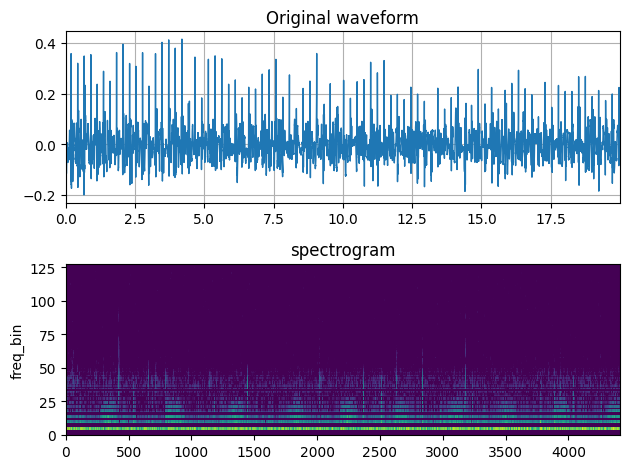

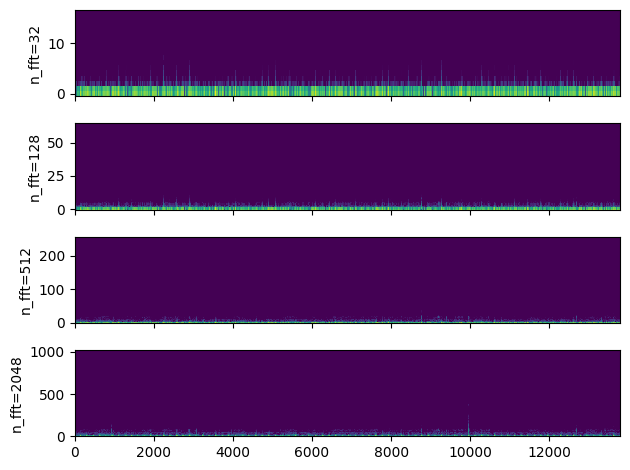

In [ ]:
import librosa
import librosa.display

from IPython.display import Audio
from matplotlib.patches import Rectangle
# from torchaudio.utils import download_asset

torch.random.manual_seed(0)

# SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
instance_file_path = 'Respiratory_Sound_Database\\Respiratory_Sound_Database\\Respiratory_Sound_Database\\audio_and_txt_files\\' +'101_1b1_Al_sc_Meditron.wav'
waveform, SAMPLE_RATE = torchaudio.load(instance_file_path)


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
   spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
   spec = spectrogram(waveform)
   specs.append(spec)
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

def parser(label):
   # instance_file_path   = r"amp_adjusted\101_1b1_Al_sc_Meditron.wav"
   # function to load files and extract features
   # file_name = os.path.join(os.path.abspath(data_dir), 'Train', str(row.ID) + '.wav')

   # handle exception to check if there isn't a file which is corrupted
   try:
      # here kaiser_fast is a technique used for faster extraction
      X, sample_rate = librosa.load(instance_file_path, res_type='kaiser_fast') 
      # we extract mfcc feature from data
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
   except Exception as e:
      print("Error encountered while parsing file: ", instance_file_path,e)
      return None, None
 
   feature = mfccs
   # label = row.Class
 
   return [feature, label]

# c,y = parser(1)
# print(c,y)

# temp = train.apply(parser, axis=1)
# temp.columns = ['feature', 'label']

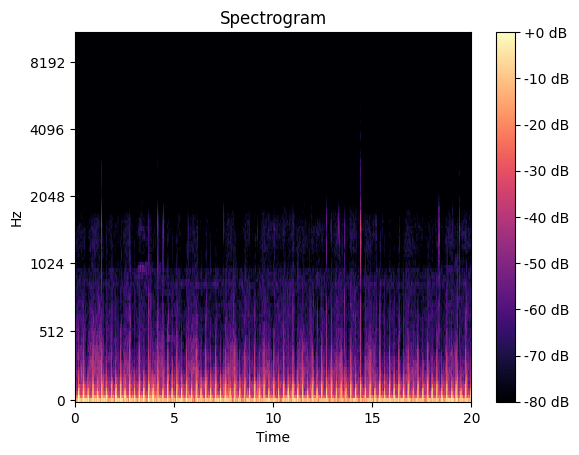

In [ ]:

# Load the audio file
# audio_file = instance_file_path
audio_folder = r"amp_adjusted/"
audio_file   = r"amp_adjusted\101_1b1_Al_sc_Meditron.wav"
# for audio_file in os.listdir(audio_folder):
y, sr = librosa.load(audio_file)

# Generate the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibels
db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

# Display the spectrogram
librosa.display.specshow(db_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

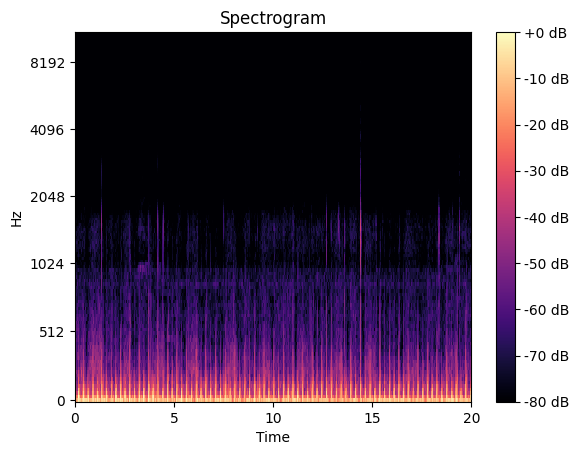

In [ ]:

y, sr = librosa.load(instance_file_path)

# Generate the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibels
db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

# Display the spectrogram
librosa.display.specshow(db_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

## dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader

# `Dataset` is a class that represents a dataset. It is a base class for creating custom datasets in PyTorch. It provides two main methods: `__len__` and `__getitem__`.
class WavAudioDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.wav_files = [f for f in os.listdir(data_dir) if f.endswith('.wav')]
        self.transform = transform

    def __len__(self):
        return len(self.wav_files)

    def __getitem__(self, idx):
        wav_file_path = os.path.join(self.data_dir, self.wav_files[idx])
        waveform, sample_rate = torchaudio.load(wav_file_path)
        
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, sample_rate


In [ ]:
from torch.utils.data import DataLoader

data_dir = r'Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files'
# transform = NormalizeAudio() 

# dataset = WavAudioDataset(data_dir, transform=transform)
dataset = WavAudioDataset(data_dir)

# DataLoader parameters
batch_size = 16
shuffle = True

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Respiratory_Sound_Database\\Respiratory_Sound_Database\\audio_and_txt_files'

In [ ]:
import os
import torchaudio
from torch.utils.data import DataLoader

data_dir = r'LungML_cross_labs\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files'

dataset = WavAudioDataset(data_dir)

batch_size = 32  
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for batch in dataloader:
    waveforms, sample_rates = batch
    # features req. are extracted only wrt to digonoses (bool or specific)
    # processing now

RuntimeError: stack expects each tensor to be equal size, but got [1, 882000] at entry 0 and [1, 293400] at entry 13

### tries/understanding

In [ ]:
import wave

# Path to your .wav file
# wav_file_path = "your_audio.wav"

for filename in os.listdir(output_directory):
    # Open the .wav file for reading
    with wave.open(filename, 'rb') as wav_file:
        # Get the number of frames in the audio
        num_frames = wav_file.getnframes()

        # Read all the frames into a list
        audio_frames = wav_file.readframes(num_frames)

        # Convert the frames to a list of integers
        audio_data = list(wave.struct.unpack('<' + 'h' * num_frames, audio_frames))

        # Find the maximum and minimum amplitudes
        max_amplitude = max(audio_data)
        min_amplitude = min(audio_data)

    print(f"Max Amplitude: {max_amplitude}")
    print(f"Min Amplitude: {min_amplitude}")


#model

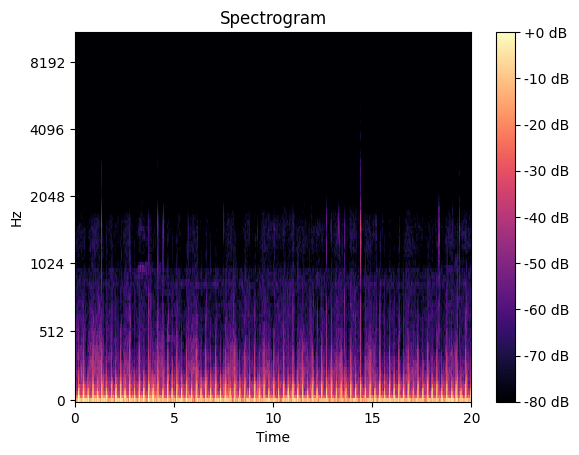

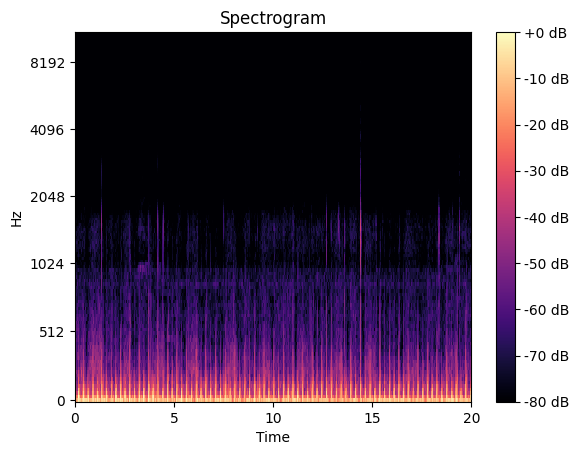

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
# Load the audio file
# audio_file = instance_file_path
audio_folder = r"amp_adjusted/"
audio_file = r"amp_adjusted\101_1b1_Al_sc_Meditron.wav"
# for audio_file in os.listdir(audio_folder):
y, sr = librosa.load(audio_file)

# Generate the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibels
db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

# Display the spectrogram
librosa.display.specshow(db_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

y, sr = librosa.load(instance_file_path)

# Generate the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibels
db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

# Display the spectrogram
librosa.display.specshow(db_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


### Trash [Old]

In [ ]:
import pandas as pd
csv_file_path = 'respiratory_data.csv'
df = pd.read_csv(csv_file_path)
print(df.head())

  Patient ID Recording Index Location Region Acoustic Channel Sound Type  \
0        101             1b1       Al    NaN               sc        NaN   
1        101             1b1       Pr    NaN               sc        NaN   
2        102             1b1       Ar    NaN               sc        NaN   
3        103             2b2       Ar    NaN               mc        NaN   
4        104             1b1       Al    NaN               sc        NaN   

  Equipment Diagnosis    Age Sex  Adult BMI  Child Weight  Child Height  \
0  Meditron      URTI   3.00   F        NaN          19.0          99.0   
1  Meditron      URTI   3.00   F        NaN          19.0          99.0   
2  Meditron   Healthy   0.75   F        NaN           9.8          73.0   
3  LittC2SE    Asthma  70.00   F      33.00           NaN           NaN   
4  Litt3200      COPD  70.00   F      28.47           NaN           NaN   

   Unnamed: 13  Unnamed: 14                                        Unnamed: 15  
0          

In [ ]:
import torchaudio
print(torchaudio.get_audio_backend())

torchaudio.set_audio_backend("soundfile")  # or "sox_io"


soundfile
